In [3]:
from sklearn import cluster, datasets, metrics, mixture, pipeline, preprocessing
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
from ipywidgets import interact


# 1. Denetimsiz Metrikler

Eger etiketler bilinmiyor ise; kumelendirmenin kalitesi, modelin kendi ciktilari kullanilarak yapilmak zorundadir. 

## 1.a. Silhouette Score

Silhouette Coefficient ([sklearn.metrics.silhouette_score](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)) bu sekilde bir degerlendirme olarak kullanilabilir, yani yuksek Silhouette Coefficient puanlari daha kaliteli bir kumelendirme anlamina gelebilir. 

Silhouette Coefficient her bir ornek icin tanimlanir ve 2 terimden olusur:

$a$: Bir ornek ile bu ornegin bagli oldugu kumenin diğer tüm noktalari arasinda bulunan ortalama mesafe.
$b$: Ayni ornek ile bu ornege en yakin kumede bulunan ornekler arasindaki ortalama mesafe.

Silhouette Coefficient, her bir ornek icin a ve b degerlerini hesaplar. Muteakiben:

$$ s = \frac{b - a}{max(a, b)}$$

### 1.a.I Calisma ornekleri

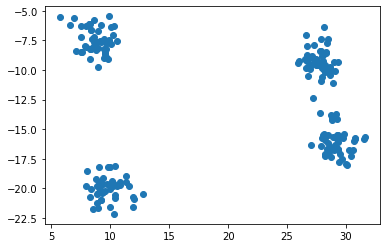

In [4]:
X, y = datasets.make_blobs(n_samples=200, centers=4, center_box=(-30, 30), random_state=30)
plt.scatter(*X.T)

In [5]:
model = cluster.KMeans(n_clusters=2)
clusters = model.fit_predict(X)

metrics.silhouette_score(X, clusters)

0.713784438514124

In [6]:
@interact(n_clusters=(2,19,1))
def silhouetteviz(n_clusters=2):
    model = cluster.KMeans(n_clusters=n_clusters)
    clusters = model.fit_predict(X)
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 2, 2)
    ss = metrics.silhouette_samples(X, clusters)
    plt.scatter(*X.T, c=ss, cmap='viridis', vmin=-1, vmax=1)
    plt.title('Silhouette samples')
    plt.colorbar().set_label("Silhouette Score per Sample")
    plt.scatter(*model.cluster_centers_.T, color='black', marker='x', s=200);
    plt.subplot(1, 2, 1, sharey=ax)
    plt.title("Silhouette Score: {:.2f}".format(metrics.silhouette_score(X, clusters)))
    plt.scatter(*X.T, c=clusters, cmap='rainbow');
    plt.scatter(*model.cluster_centers_.T, c=range(model.n_clusters), marker='*', s=200, cmap='rainbow', edgecolors='k');

interactive(children=(IntSlider(value=2, description='n_clusters', max=19, min=2), Output()), _dom_classes=('w…

In [6]:
model = cluster.KMeans(n_clusters=3)
clusters = model.fit_predict(X)

metrics.silhouette_score(X, clusters)

0.8139485866008165

In [7]:
model = cluster.KMeans(n_clusters=4)
clusters = model.fit_predict(X)

metrics.silhouette_score(X, clusters)

0.8004807817566464

In [8]:
model = cluster.KMeans(n_clusters=100)
clusters = model.fit_predict(X)

metrics.silhouette_score(X, clusters)

0.37583134775137994

In [9]:
try_ks = list(range(2,10)) + [15, 20, 30, 50, 100, 199]
scores = []
for k in try_ks:
    model = cluster.KMeans(n_clusters=k)
    clusters = model.fit_predict(X)
    score = metrics.silhouette_score(X, clusters)
    scores.append(score)

Text(0.5, 1.0, 'Silhouette score vs # clusters')

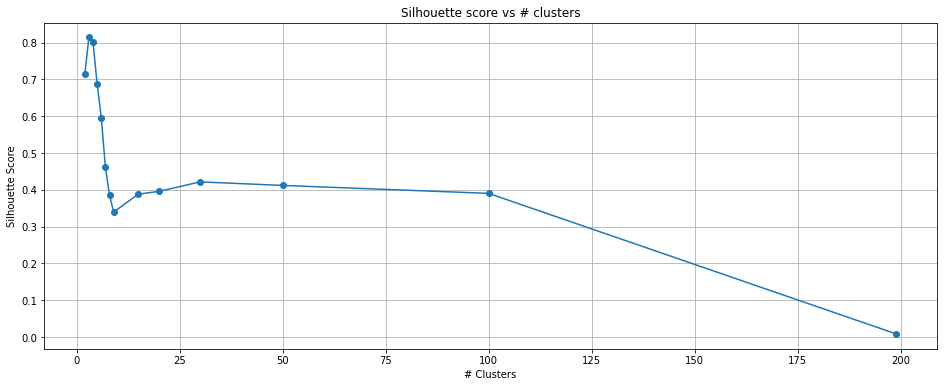

In [10]:
plt.figure(figsize=(16,6))
plt.plot(try_ks, scores, marker='o')
plt.grid()
plt.xlabel("# Clusters")
plt.ylabel('Silhouette Score')
plt.title('Silhouette score vs # clusters')

### 1.a.II Avantajlar

- Skor -1 ile +1 arasinda sinirlandirilmistir. Yanlis kumelendirme icin -1, yuksek kaliteli (yogunluklu) kumelendirme ise +1 degerleri alir.
- Kumeler kendi iclerinde yogun ve birbirinden uzakta ise skor yuksektir. Bu da standart kumeleme konseptine uymaktadir.

Silhouette score = 0 nasil gozukur?

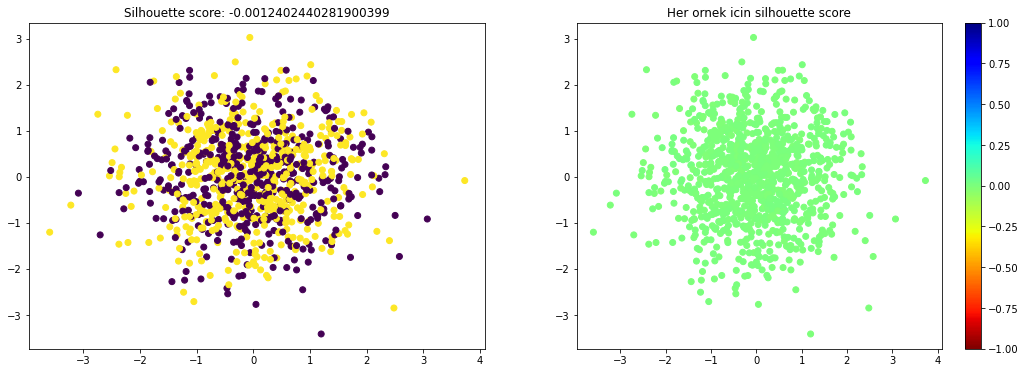

In [11]:
X = np.random.randn(1000, 2)
clusters = np.random.randint(2, size=1000)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.scatter(*X.T, c=clusters)
plt.title(f"Silhouette score: {metrics.silhouette_score(X, clusters)}");

plt.subplot(1, 2, 2)
scores = metrics.silhouette_samples(X, clusters)
plt.scatter(*X.T, c=scores, cmap='jet_r', vmin=-1, vmax=1)
plt.title("Her ornek icin silhouette score");
plt.colorbar();

Silhouette score = -1 nasil gozukur?

In [12]:
X, y = datasets.make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1.0, random_state=32)
c = cluster.KMeans(n_clusters=3).fit_predict(X)
X = np.r_[X, [[0, 8]]]
c = np.r_[c, [1]]
scores = metrics.silhouette_samples(X, c)

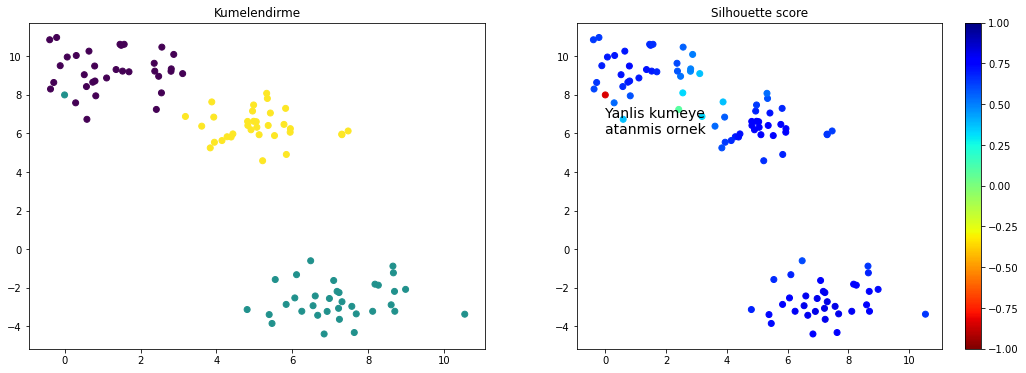

In [13]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.scatter(*X.T, c=c)
plt.title("Kumelendirme")
plt.subplot(1, 2, 2)
plt.scatter(*X.T, c=scores, cmap='jet_r', vmin=-1, vmax=1)
plt.text(0, 6, "Yanlis kumeye \natanmis ornek", color='k', fontsize=14)
plt.title("Silhouette score")
plt.colorbar();


### 1.a.III Dezavantajlar

- Silhouette Coefficient degerleri, konveks kumeler haricindeki kumeleme konseptlerine uygun olmayabilir.

Asagida Silhouette Score olcumunun beklenen sonuclar ile uymadigi bazi ornekler gorecegiz:

#### 1.a.III.1 Es varyansa sahip olmayan kumeler

In [14]:
e1 = scs.norm([0, 0], [5, 5])
e2 = scs.norm([10, -10], [2, 2])
kucuklu_buyuklu = e1.rvs((1000, 2)).tolist() + e2.rvs((1000, 2)).tolist()
kucuklu_buyuklu = np.array(kucuklu_buyuklu)
kucuklu_buyuklu_y = [0] * 1000 + [1] * 1000

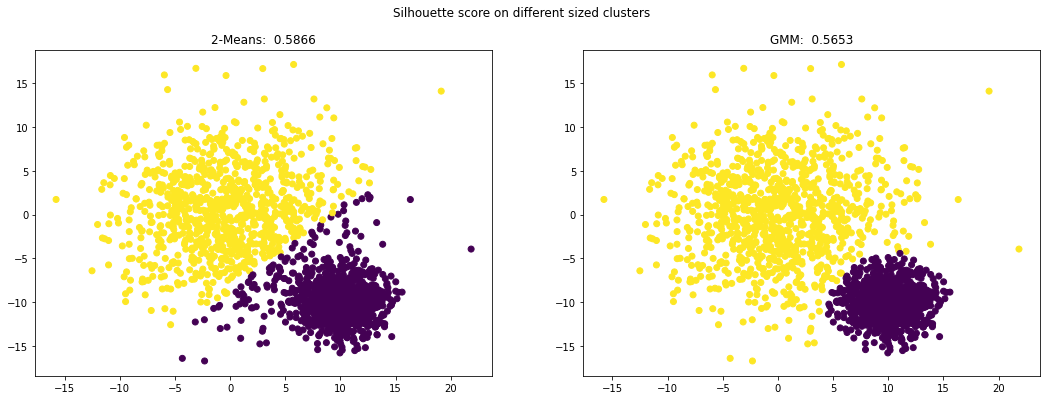

In [15]:
kmeans = cluster.KMeans(n_clusters=2)
c1 = kmeans.fit_predict(kucuklu_buyuklu)

gmm = mixture.GaussianMixture(n_components=2)
c2 = gmm.fit_predict(kucuklu_buyuklu)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.scatter(*kucuklu_buyuklu.T, c=c1)
plt.title(f"2-Means: {metrics.silhouette_score(kucuklu_buyuklu, c1): .4f}")
plt.subplot(1, 2, 2)
plt.scatter(*kucuklu_buyuklu.T, c=c2)
plt.title(f"GMM: {metrics.silhouette_score(kucuklu_buyuklu, c2): .4f}")
plt.suptitle("Silhouette score on different sized clusters");

#### 1.a.III.2 Duzensiz kumeler

In [16]:
aylar, _ = datasets.make_moons(n_samples=200, noise=0.09, random_state=32)

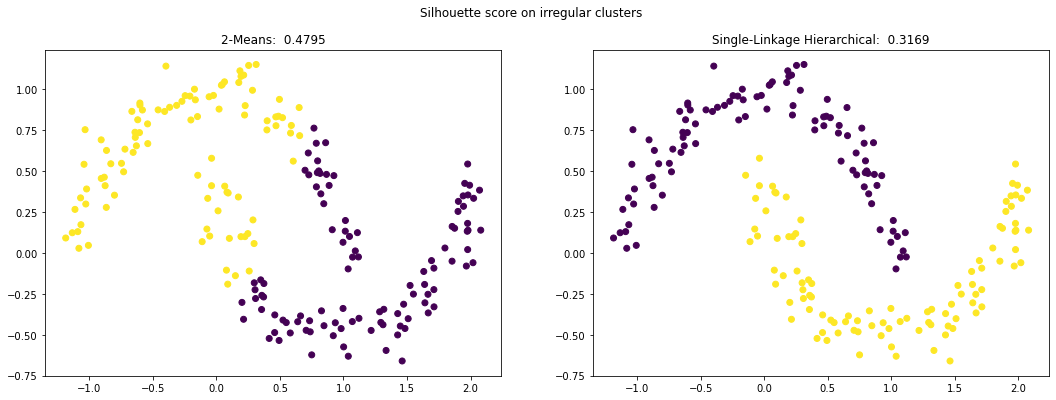

In [17]:
kmeans = cluster.KMeans(n_clusters=2)
c1 = kmeans.fit_predict(aylar)

agg = cluster.AgglomerativeClustering(n_clusters=2, linkage='single')
c2 = agg.fit_predict(aylar)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.scatter(*aylar.T, c=c1)
plt.title(f"2-Means: {metrics.silhouette_score(aylar, c1): .4f}")
plt.subplot(1, 2, 2)
plt.scatter(*aylar.T, c=c2)
plt.title(f"Single-Linkage Hierarchical: {metrics.silhouette_score(aylar, c2): .4f}")
plt.suptitle("Silhouette score on irregular clusters");

#### 1.a.III.3 Olceklenmemis degiskenler

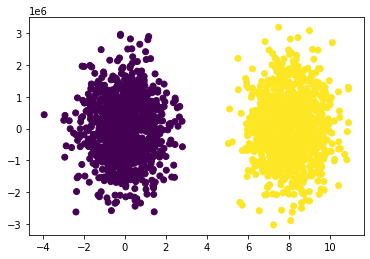

In [18]:
X = np.random.randn(1000, 2).tolist() + (np.random.randn(1000, 2) + [8, 0]).tolist()
y = [0] * 1000 + [1] * 1000
X = np.array(X)
X = X * [1, 1e6]
plt.scatter(*X.T, c=y)

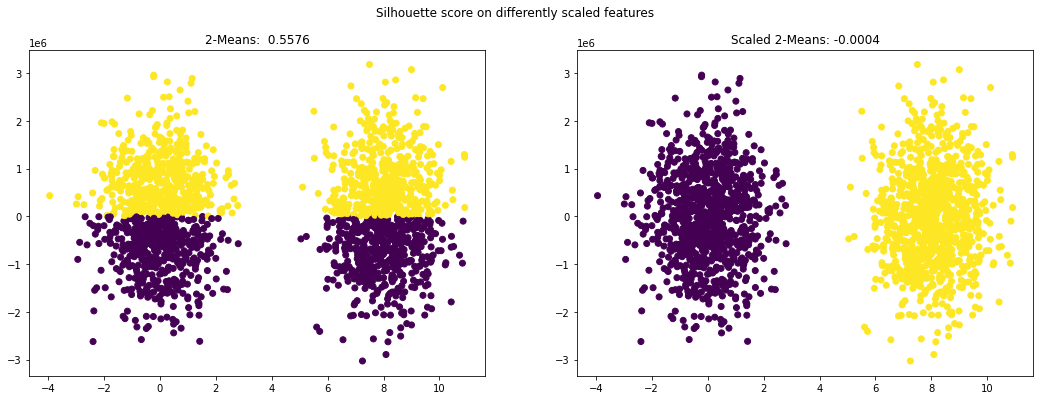

In [19]:
kmeans = cluster.KMeans(n_clusters=2)
c1 = kmeans.fit_predict(X)

scaled_kmeans = pipeline.Pipeline([('scale', preprocessing.StandardScaler()), ('cluster', cluster.KMeans(n_clusters=2))])
c2 = scaled_kmeans.fit_predict(X)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.scatter(*X.T, c=c1)
plt.title(f"2-Means: {metrics.silhouette_score(X, c1): .4f}")
plt.subplot(1, 2, 2)
plt.scatter(*X.T, c=c2)
plt.title(f"Scaled 2-Means: {metrics.silhouette_score(X, c2): .4f}")
plt.suptitle("Silhouette score on differently scaled features");

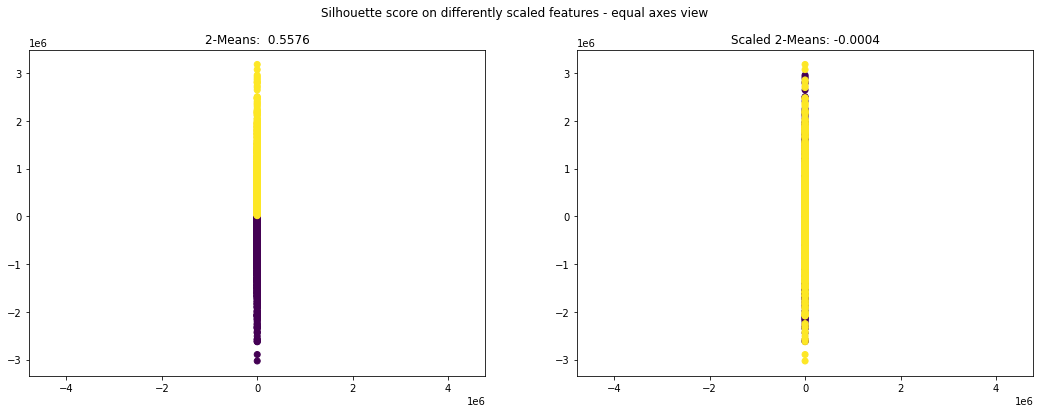

In [20]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.scatter(*X.T, c=c1)
plt.title(f"2-Means: {metrics.silhouette_score(X, c1): .4f}")
plt.axis('equal')
plt.subplot(1, 2, 2)
plt.scatter(*X.T, c=c2)
plt.title(f"Scaled 2-Means: {metrics.silhouette_score(X, c2): .4f}")
plt.axis('equal')
plt.suptitle("Silhouette score on differently scaled features - equal axes view");

## 1.b. Calinski-Harabasz

Eger etiketler bilinmiyorsa, Calinski-Harabasz index (sklearn.metrics.calinski_harabasz_score) - ayni zamanda Variance Ratio Criterion - kullanilabilir, yani yuksek Calinski-Harabasz score puanlari daha kaliteli bir kumelendirme anlamina gelebilir.

Hesaplanan indeks, her bir kume icin, kumeler arasi sacilim ve kume icindeki sacilimin oranini ifade eder. (Sacilim, mesafeler karelerinin toplami olarak ifade edilir)

- [Calinski-Harabasz Index (sklearn referans)](https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index)
- [Caliński, T., & Harabasz, J. (1974)](https://www.researchgate.net/publication/233096619_A_Dendrite_Method_for_Cluster_Analysis)

### 1.b.I Calisma prensibi ornekleri

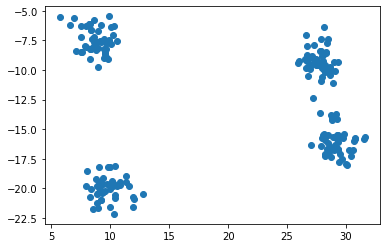

In [21]:
X, y = datasets.make_blobs(n_samples=200, centers=4, center_box=(-30, 30), random_state=30)
plt.scatter(*X.T);

2'den 199'a kadar farkli kume sayilari ile K-means sonucunda alinan Calinski-Harabasz skoru degerleri:

[]

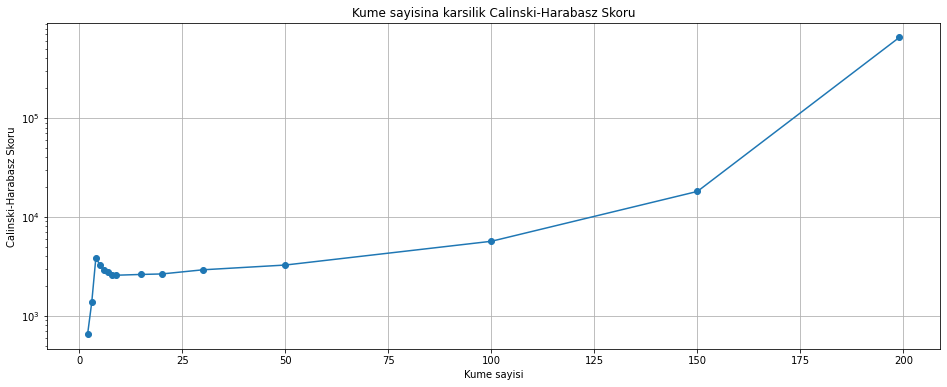

In [22]:
try_ks = list(range(2,10)) + [15, 20, 30, 50, 100, 150, 199]
scores = []

for k in try_ks:
    model = cluster.KMeans(n_clusters=k)
    clusters = model.fit_predict(X)
    score = metrics.calinski_harabasz_score(X, clusters)
    scores.append(score)
    
plt.figure(figsize=(16,6))
plt.plot(try_ks, scores, marker='o')
plt.grid()
plt.xlabel("Kume sayisi")
plt.ylabel('Calinski-Harabasz Skoru')
plt.title('Kume sayisina karsilik Calinski-Harabasz Skoru')
plt.semilogy()

### 1.b.II Avantajlari

- Kumeler yogun ve birbirinden uzakta ise skor yuksektir (Konveks kumeler konseptine uygun)
- Skorlama hizli yapilir.

### 1.b.III Dezavantajlar

- Konveks olmayan kume bicimleri icin uygun bir skorlama teknigi degildir.

#### 1.b.III.1 Es varyansa sahip olmayan kumeler

In [23]:
e1 = scs.norm([0, 0], [5, 5])
e2 = scs.norm([10, -10], [2, 2])
kucuklu_buyuklu = e1.rvs((1000, 2)).tolist() + e2.rvs((1000, 2)).tolist()
kucuklu_buyuklu = np.array(kucuklu_buyuklu)
kucuklu_buyuklu_y = [0] * 1000 + [1] * 1000

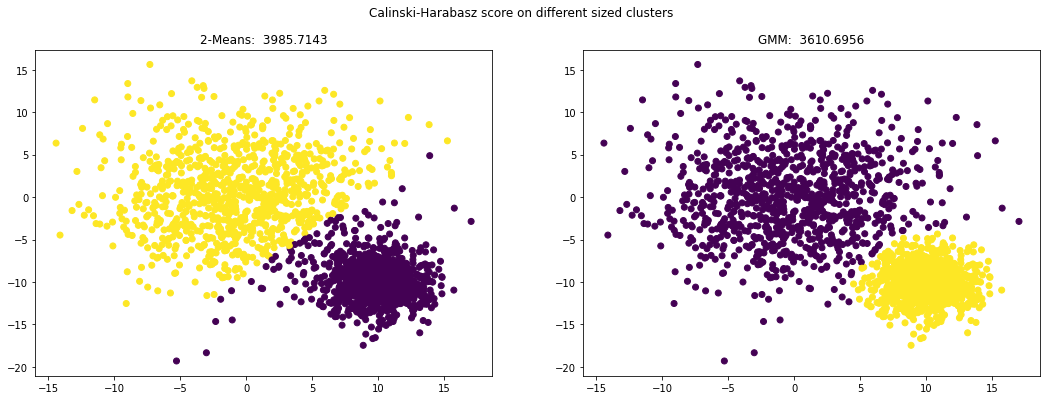

In [24]:
kmeans = cluster.KMeans(n_clusters=2)
c1 = kmeans.fit_predict(kucuklu_buyuklu)

gmm = mixture.GaussianMixture(n_components=2)
c2 = gmm.fit_predict(kucuklu_buyuklu)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.scatter(*kucuklu_buyuklu.T, c=c1)
plt.title(f"2-Means: {metrics.calinski_harabasz_score(kucuklu_buyuklu, c1): .4f}")
plt.subplot(1, 2, 2)
plt.scatter(*kucuklu_buyuklu.T, c=c2)
plt.title(f"GMM: {metrics.calinski_harabasz_score(kucuklu_buyuklu, c2): .4f}")
plt.suptitle("Calinski-Harabasz score on different sized clusters");

#### 1.b.III.2 Duzensiz kumeler

In [25]:
aylar, _ = datasets.make_moons(n_samples=200, noise=0.09, random_state=32)

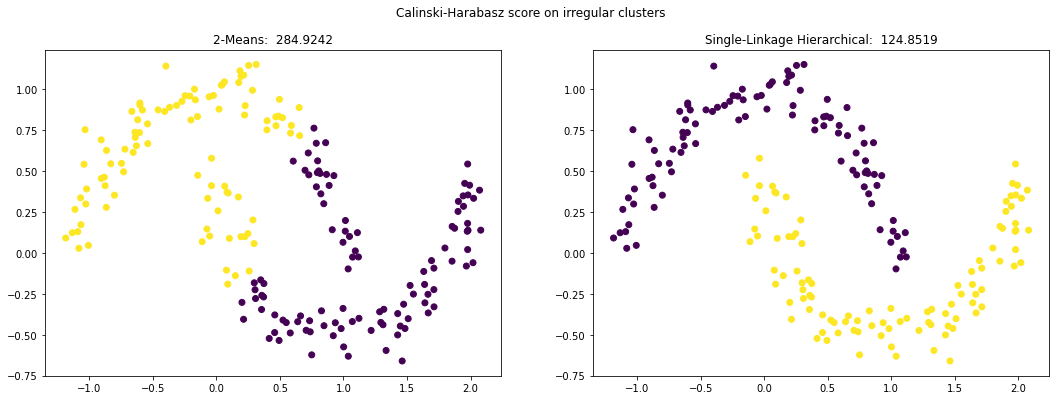

In [26]:
kmeans = cluster.KMeans(n_clusters=2)
c1 = kmeans.fit_predict(aylar)

agg = cluster.AgglomerativeClustering(n_clusters=2, linkage='single')
c2 = agg.fit_predict(aylar)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.scatter(*aylar.T, c=c1)
plt.title(f"2-Means: {metrics.calinski_harabasz_score(aylar, c1): .4f}")
plt.subplot(1, 2, 2)
plt.scatter(*aylar.T, c=c2)
plt.title(f"Single-Linkage Hierarchical: {metrics.calinski_harabasz_score(aylar, c2): .4f}")
plt.suptitle("Calinski-Harabasz score on irregular clusters");

#### 1.b.III.3 Olceklenmemis veriler

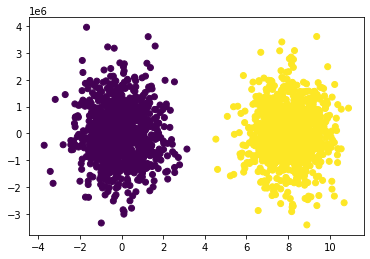

In [27]:
X = np.random.randn(1000, 2).tolist() + (np.random.randn(1000, 2) + [8, 0]).tolist()
y = [0] * 1000 + [1] * 1000
X = np.array(X)
X = X * [1, 1e6]
plt.scatter(*X.T, c=y)

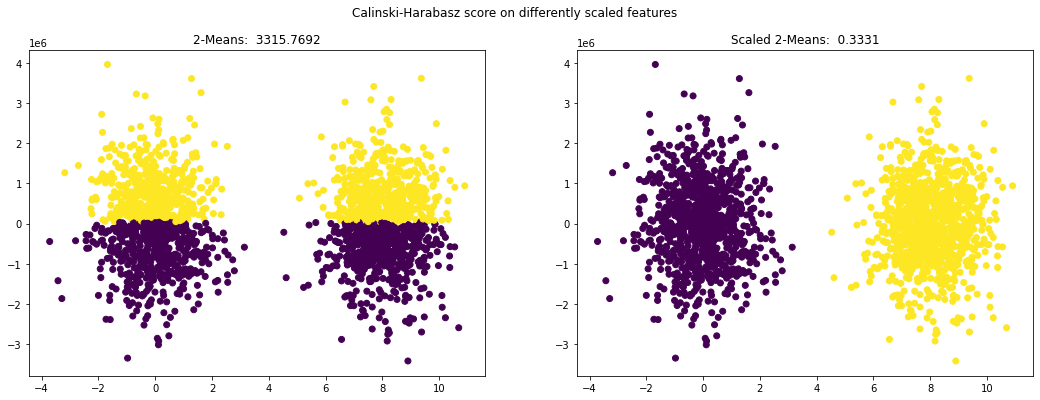

In [28]:
kmeans = cluster.KMeans(n_clusters=2)
c1 = kmeans.fit_predict(X)

scaled_kmeans = pipeline.Pipeline([('scale', preprocessing.StandardScaler()), ('cluster', cluster.KMeans(n_clusters=2))])
c2 = scaled_kmeans.fit_predict(X)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.scatter(*X.T, c=c1)
plt.title(f"2-Means: {metrics.calinski_harabasz_score(X, c1): .4f}")
plt.subplot(1, 2, 2)
plt.scatter(*X.T, c=c2)
plt.title(f"Scaled 2-Means: {metrics.calinski_harabasz_score(X, c2): .4f}")
plt.suptitle("Calinski-Harabasz score on differently scaled features");

# 2. Denetimli Metrikler

Kumelendirme sonuclarini bilinen etiketlere gore uyumluluk testlerine tabi tutacaksak, bu kisimdaki metrikler isimize yarayacaktir.

> Denetimli metrikler hesaplanirken kume numaralari ile etiketlerin mutlak degerlerini karsilastirip `accuracy`, `recall`, `precision` gibi metrikler hesaplamak anlamsiz olacaktir.
> 
> Bundan ziyade, ayni etiketlerin ayni kumelerde toplanip toplanmadigina yonelik hesaplamalar gerekir.

## 2.a. Homogenity, Completeness, V-Measure

 Örneklerin etiket bilgisi göz önüne alındığında, koşullu entropi analizini kullanarak bazı akla yatkin metrikleri tanımlamak mümkündür.

- **Homogeneity**: Her kume, yalnizca bir tur sinif icermelidir.
- **Completeness**: Bir sinifin tum ornekleri ayni kumeye atanmalidir.

### 2.a.I Calisma prensibi ornekleri

In [29]:
e1 = scs.norm([0, 0], [5, 5])
e2 = scs.norm([10, -10], [2, 2])
kucuklu_buyuklu = e1.rvs((1000, 2)).tolist() + e2.rvs((1000, 2)).tolist()
kucuklu_buyuklu = np.array(kucuklu_buyuklu)
kucuklu_buyuklu_y = [0] * 1000 + [1] * 1000

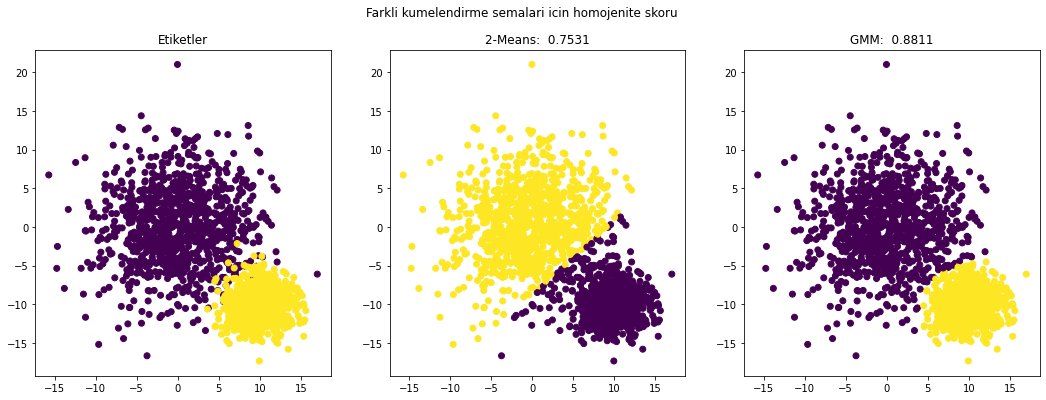

In [30]:
kmeans = cluster.KMeans(n_clusters=2)
c1 = kmeans.fit_predict(kucuklu_buyuklu)

gmm = mixture.GaussianMixture(n_components=2)
c2 = gmm.fit_predict(kucuklu_buyuklu)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.scatter(*kucuklu_buyuklu.T, c=kucuklu_buyuklu_y)
plt.title("Etiketler")
plt.subplot(1, 3, 2)
plt.scatter(*kucuklu_buyuklu.T, c=c1)
plt.title(f"2-Means: {metrics.homogeneity_score(kucuklu_buyuklu_y, c1): .4f}")
plt.subplot(1, 3, 3)
plt.scatter(*kucuklu_buyuklu.T, c=c2)
plt.title(f"GMM: {metrics.homogeneity_score(kucuklu_buyuklu_y, c2): .4f}")
plt.suptitle("Farkli kumelendirme semalari icin homojenite skoru");

In [31]:
@interact
def hcvviz(n_clusters=(2,10,1)):
    X, y = datasets.make_blobs(n_samples=200, centers=3, random_state=32)

    kmeans = cluster.KMeans(n_clusters=n_clusters)
    c1 = kmeans.fit_predict(X)
    plt.figure(figsize=(18, 6))
    plt.suptitle(f"{n_clusters}-Means")
    plt.subplot(1, 2, 1)
    plt.title("Etiketler")
    plt.scatter(*X.T, c=y)
    plt.subplot(1, 2, 2)
    plt.scatter(*X.T, c=c1, cmap="rainbow")
    plt.title(
        f"Kumeler\nHomojenite skoru: {metrics.homogeneity_score(y, c1): .4f}, Completeness skoru: {metrics.completeness_score(y, c1): .4f}"
        );

interactive(children=(IntSlider(value=6, description='n_clusters', max=10, min=2), Output()), _dom_classes=('w…

### 2.a.II V-Measure

Yukaridaki interaktif hucrede kume sayisi ile *homogeneity*-*completeness* metriklerinin ters orantili olarak degistigini fakat belli bir noktada ikisinin de dengede ve iyi sonuclar verdigini gozlemlediniz.

Tipki *precision*-*recall*'da oldugu gibi, *homogeneity* ve *completeness* metrikleri icin de harmonik bir ortalama hesaplayabiliriz.

$$ v = \frac{(1 + \beta) \times homogeneity \times completeness}{(\beta \times homogeneity + completeness )} $$

In [32]:
import warnings

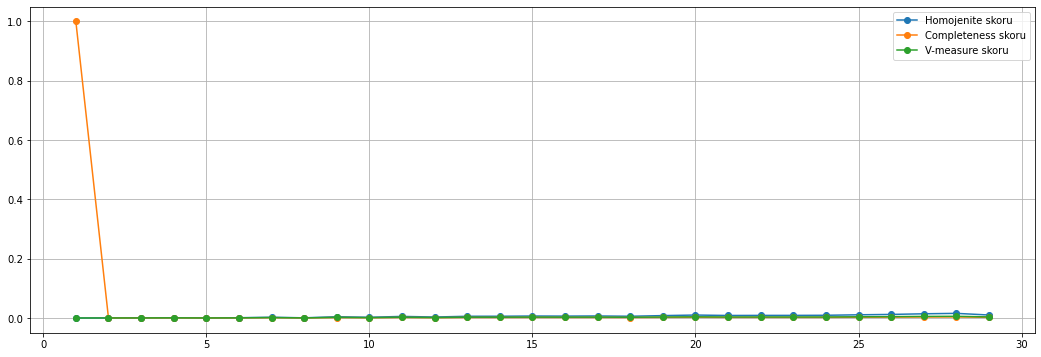

In [33]:
scores = []
for k in range(1,30):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        kmeans = cluster.KMeans(n_clusters=k)
        c1 = kmeans.fit_predict(X)
        scores.append(metrics.homogeneity_completeness_v_measure(y, c1))

scores = np.array(scores)
plt.figure(figsize=(18, 6))
plt.plot(range(1,30), scores[:,0], marker='o', label="Homojenite skoru")
plt.plot(range(1,30), scores[:,1], marker='o', label="Completeness skoru")
plt.plot(range(1,30), scores[:,2], marker='o', label="V-measure skoru")
plt.legend()
plt.grid()

## 2.b. Rand Index

Bu metrikte etiketler ile kume atamalarinin benzerlikleri, mutlak degerer goz ardi edilerek hesaplanir.

[Rand Index (sklearn referans)](https://scikit-learn.org/stable/modules/clustering.html#rand-index)

In [34]:
@interact
def randviz(n_clusters=(2,10,1)):
    kmeans = cluster.KMeans(n_clusters=n_clusters)
    c1 = kmeans.fit_predict(kucuklu_buyuklu)

    gmm = mixture.GaussianMixture(n_components=n_clusters)
    c2 = gmm.fit_predict(kucuklu_buyuklu)

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.scatter(*kucuklu_buyuklu.T, c=kucuklu_buyuklu_y)
    plt.title("Ground Truth")
    plt.subplot(1, 3, 2)
    plt.scatter(*kucuklu_buyuklu.T, c=c1, cmap="rainbow")
    plt.title(f"{n_clusters}-Means: {metrics.rand_score(kucuklu_buyuklu_y, c1): .4f}")
    plt.subplot(1, 3, 3)
    plt.scatter(*kucuklu_buyuklu.T, c=c2, cmap="rainbow")
    plt.title(f"GMM: {metrics.rand_score(kucuklu_buyuklu_y, c2): .4f}")
    plt.suptitle("Rand index on different sized clusters");

interactive(children=(IntSlider(value=6, description='n_clusters', max=10, min=2), Output()), _dom_classes=('w…

## 2.c. Mutual Information Score

Mutual Information Gain (MI Gain), ayni verinin iki farkli etiketlendirmesi arasindaki benzerligi olcmek icin kullanilir.

> Iki farkli etiketlendirme, **gercek etiketler vs kumeler** olabilecegi gibi **kumelendirme 1 vs kumelendirme 2** de olabilir.

**MI** simetrik bir skordur - $U$ ve $V$ iki ayri etiketlendirme semasi ise $MI(U, V) = MI(V, U)$


$$ MI(U, V) = \sum_{i=1}^{|U|}{ \sum_{j=1}^{|V|}{ \frac{|U_i \cap V_j | }{N} \log{ \frac{N |U_i \cap V_j  |}{|U_i| |V_j|}  } }   }$$

[mutual info score (sklearn referans)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html)

In [51]:
@interact(n_clusters=(2,10,1))
def migviz(n_clusters=2):
    kmeans = cluster.KMeans(n_clusters=n_clusters)
    c1 = kmeans.fit_predict(kucuklu_buyuklu)

    gmm = mixture.GaussianMixture(n_components=n_clusters)
    c2 = gmm.fit_predict(kucuklu_buyuklu)

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 5, 1)
    plt.scatter(*kucuklu_buyuklu.T, c=kucuklu_buyuklu_y)
    plt.title("Ground Truth")
    plt.subplot(1, 5, 3)
    plt.scatter(*kucuklu_buyuklu.T, c=c1, cmap="rainbow")
    plt.title(f"{n_clusters}-Means: {metrics.mutual_info_score(kucuklu_buyuklu_y, c1): .4f}")
    plt.subplot(1, 5, 4)
    plt.scatter(*kucuklu_buyuklu.T, c=c2, cmap="rainbow")
    plt.title(f"GMM: {metrics.mutual_info_score(kucuklu_buyuklu_y, c2): .4f}")
    plt.subplot(1, 5, 5)
    plt.scatter(*kucuklu_buyuklu.T, c=kucuklu_buyuklu_y, cmap="rainbow")
    plt.title(f"Orjinal etiketler: {metrics.mutual_info_score(kucuklu_buyuklu_y, kucuklu_buyuklu_y): .4f}")
    plt.subplot(1, 5, 2)
    rassal_kumeleme = np.random.choice(range(n_clusters), size=kucuklu_buyuklu.shape[0])
    plt.scatter(*kucuklu_buyuklu.T, c=rassal_kumeleme, cmap="rainbow")
    plt.title(f"Rassal kumeleme: {metrics.mutual_info_score(kucuklu_buyuklu_y, rassal_kumeleme): .4f}")
    plt.suptitle("Mutual information gain on different sized clusters");

interactive(children=(IntSlider(value=2, description='n_clusters', max=10, min=2), Output()), _dom_classes=('w…

Orijinal etiketler ile `0.6931` ?

In [54]:
-2*(0.5 * np.log(0.5))

0.6931471805599453

Iki tur etiket bulundugunda ve etiketler tamamen uyustugunda alinabilecek maksimum MI skoru.